# Amazon Classifcation 

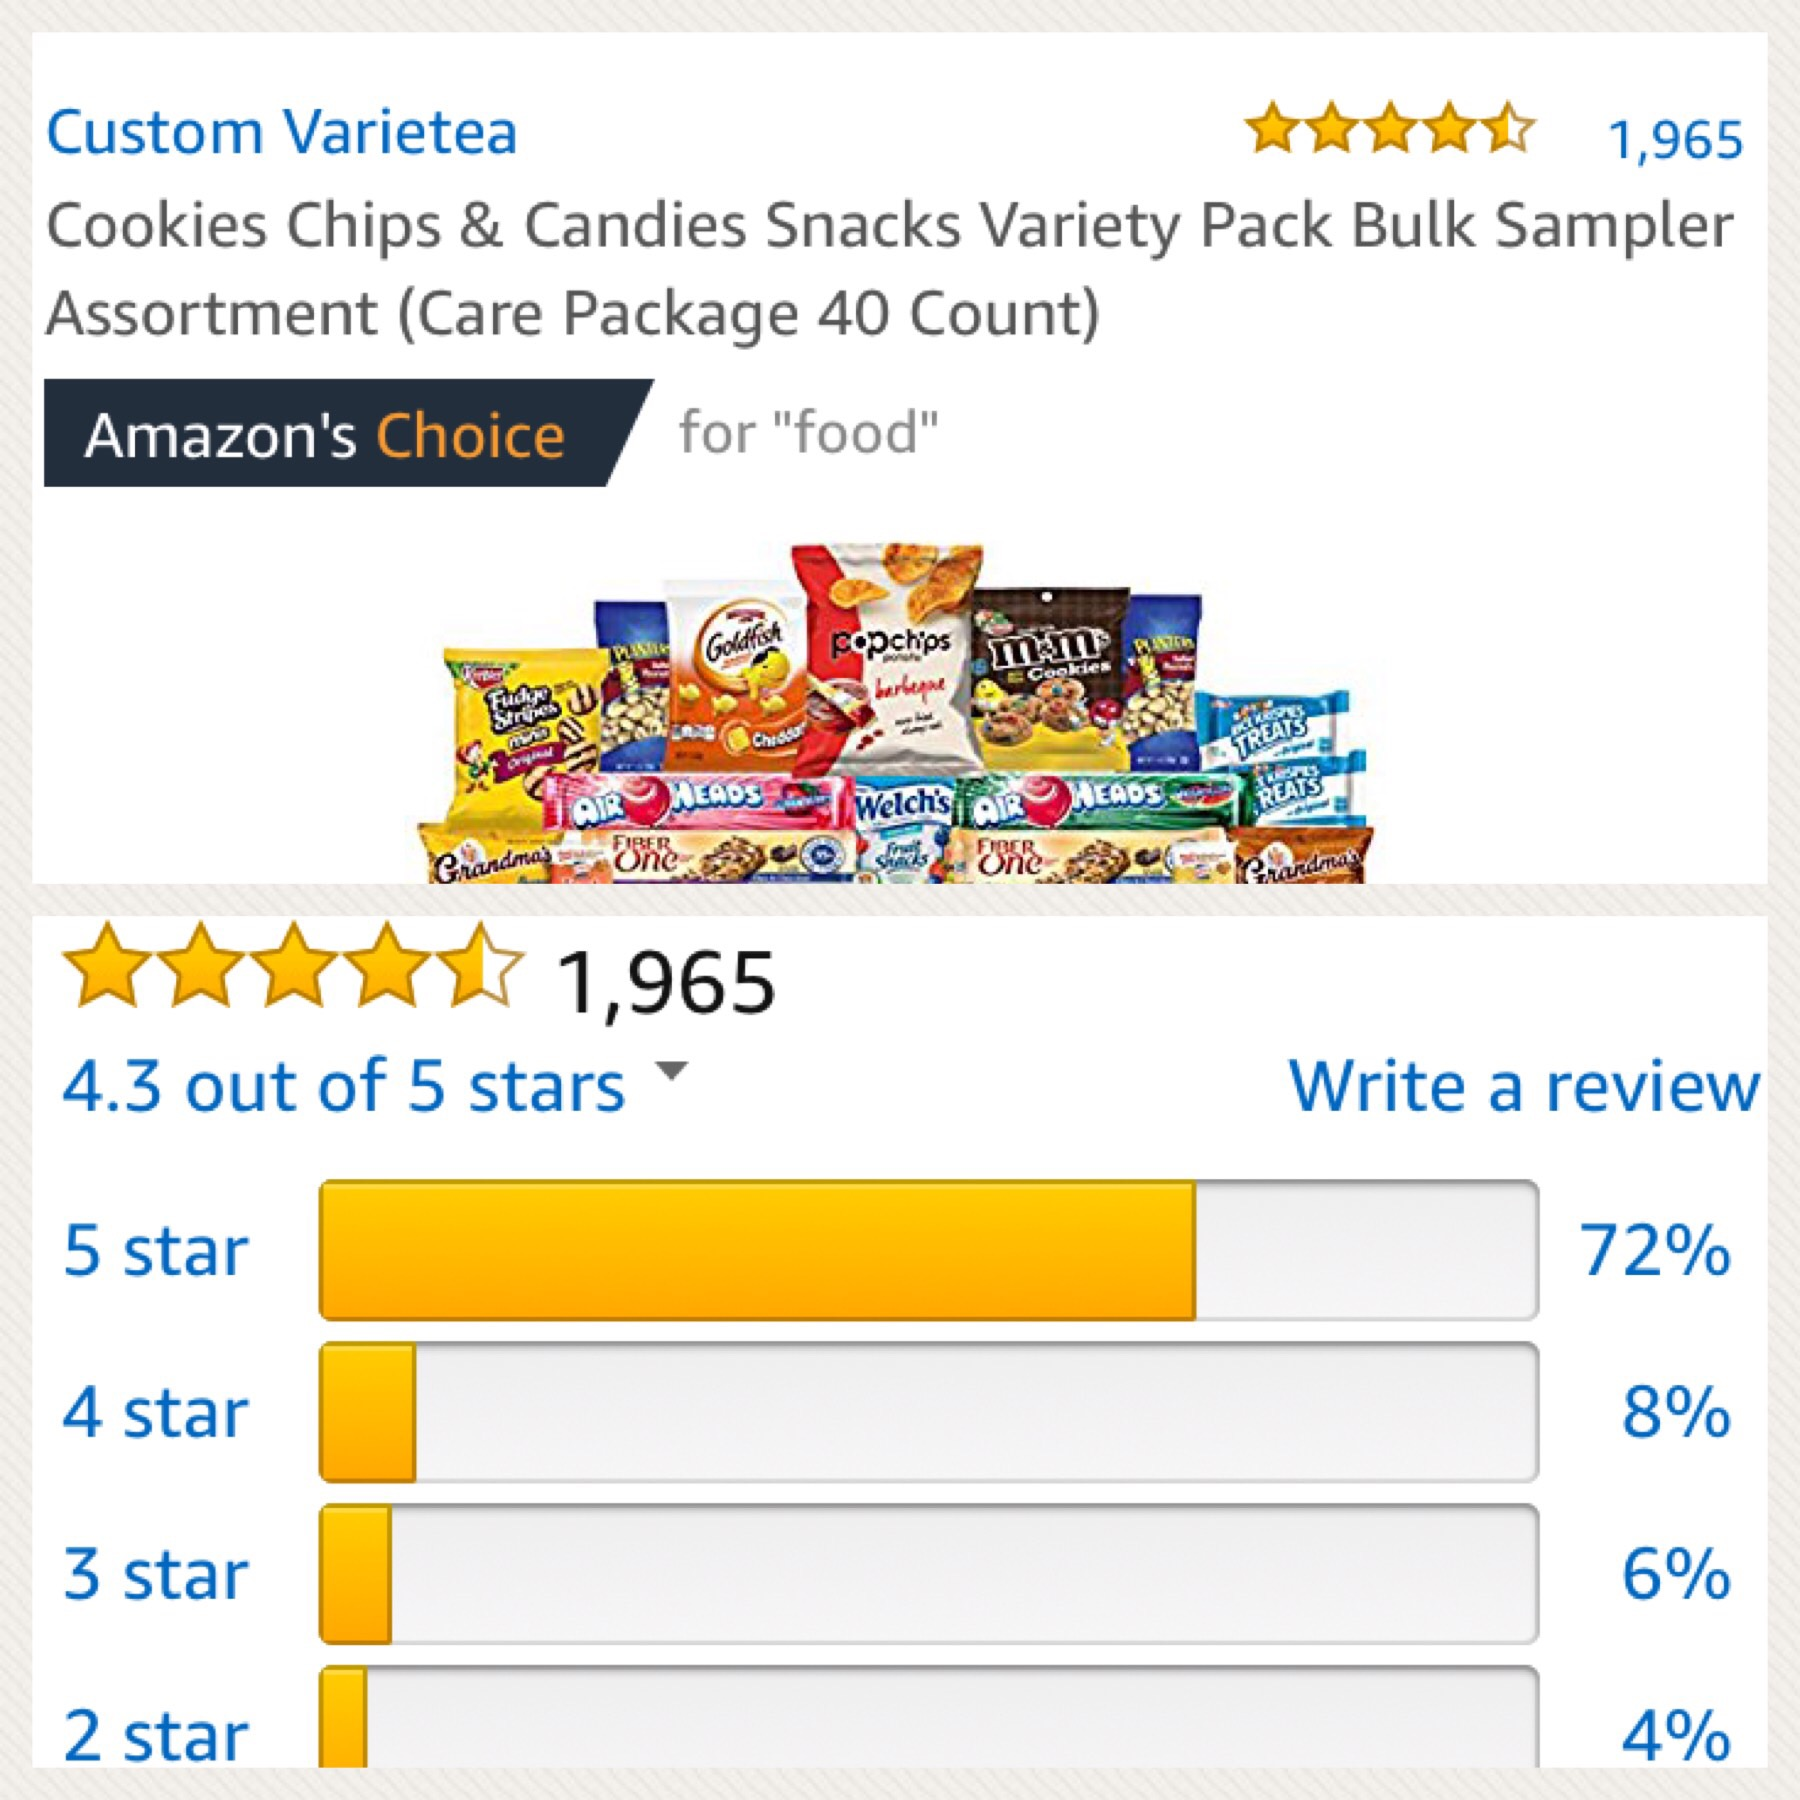

In [1]:
from IPython.display import Image
Image(filename='amazon.png')
Image(filename='IMG_3294.JPG')

# Project Overview 

Background: Recently more and more Amazon sellers realized how customers’ reviews can impact other buyers’ decision making. Since most of customers will hesitate to make a purchase decision if the product has a negative review.  As an analyst, my goal is to help the business to provide the good shopping experience. So, I want to develop the model to predict if a review is helpful or not helpful from sentiment analysis.  Then the modeling outcome will help Amazon’s merchants have better understand about customers’ attitudes towards reviews.

In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame, datetime
from subprocess import check_output
from datetime import datetime, timedelta, time
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as cm
import seaborn as sns

# 1. Data Preparation 

## Clean Numeric Data
+ Clean missing value
+ Check duplicate 

In [3]:
amazon = pd.read_csv('Reviews.csv')
amazon.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


+ Id
+ ProductId - unique identifier for the product
+ UserId - unqiue identifier for the user
+ ProfileName
+ HelpfulnessNumerator - number of users who found the review helpful
+ HelpfulnessDenominator - number of users who indicated whether they found the review helpful
+ Score - rating between 1 and 5
+ Time - timestamp for the review
+ Summary - brief summary of the review
+ Text - text of the review

In [4]:
#check number of observations and row
print (amazon.shape)

(568454, 10)


In [5]:
#check missing value 
amazon.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   26
Text                       0
dtype: int64

In [6]:
# Remove missing values
amazon= amazon.dropna(subset=['ProfileName','Summary'])
amazon.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [7]:
#check number of observations and row
print (amazon.shape)

(568412, 10)


In [8]:
# covert time
amazon['date_time']=pd.to_datetime(amazon['Time'],unit='s')
amazon['date']=pd.to_datetime(amazon['date_time'],unit='d')

In [9]:
amazon.date_time.describe()

count                  568412
unique                   3168
top       2012-10-16 00:00:00
freq                     1143
first     1999-10-08 00:00:00
last      2012-10-26 00:00:00
Name: date_time, dtype: object

In [11]:
amazon['Helpful_pct'] = amazon['HelpfulnessNumerator'] / amazon['HelpfulnessDenominator']
amazon['Helpful_pct'].describe()

count    298372.000000
mean          0.777035
std           0.346273
min           0.000000
25%           0.600000
50%           1.000000
75%           1.000000
max           3.000000
Name: Helpful_pct, dtype: float64

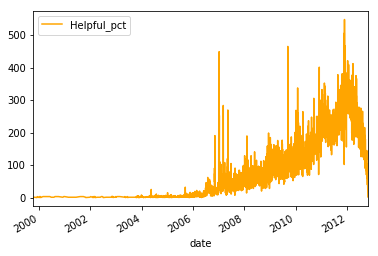

In [13]:
## Helpfulness count, exclude HelpfulnessDenominator is zero
time1=amazon[['date','Helpful_pct']].copy()
time1['Helpful_pct']=amazon.groupby(['date']).Helpful_pct.transform('count')
time1.set_index(['date'],inplace=True)
time1.sort_index(inplace=True)
time1.plot(color='orange')

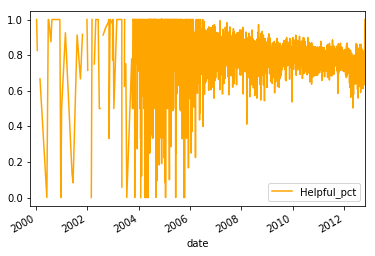

In [12]:
## Average Helpfulness
time1=amazon[['date','Helpful_pct']].copy()
time1['Helpful_pct']=time1.groupby(['date']).Helpful_pct.transform('mean')
time1.set_index(['date'],inplace=True)
time1.sort_index(inplace=True)
time1.plot(color='orange')

####  After remove missing value and covert time formate. The dataset contains 568,412 food reviews from Amazon users left from 1999 Oct to 2012 Oct.

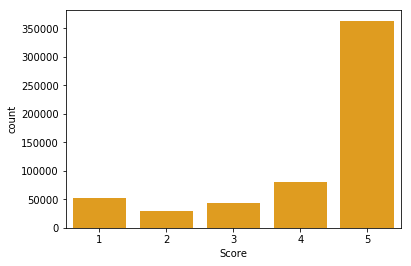

In [14]:
sns.countplot(amazon['Score'],color="orange")
plt.show()

In [23]:
p=amazon.Score.value_counts()/len(amazon.Score)
p

5    0.638817
4    0.141895
1    0.091947
3    0.075014
2    0.052326
Name: Score, dtype: float64

In [83]:
print("Average Score: ",np.mean(amazon.Score))
print("Median Score: ",np.median(amazon.Score))

Average Score:  4.183307178595808
Median Score:  5.0


####  The distribution of rating among all of the reviews. We see that 5-star reviews constitute a large proportion (64%) of all reviews. The next most prevalent rating is 4-stars(14%), followed by 1-star (9%), 3-star (8%), and finally 2-star reviews (5%). Majority of Scores are around 4 to 5, and average score is 4.18. The distribution is very skewed to the left. 

In [24]:
products = amazon['Score'].groupby(amazon['ProductId']).count()
print(products.count())

74258


In [27]:
amazon['chk']=amazon.duplicated(['Text'])
amazon['chk'].sum()

174846

#### There are 74,258 unique products 

## Cleaning Text
+ Using lemmatization as it was giving better results than stemming.  
+ lower case 
+ Removing punctuation and stopwords

In [39]:
from scipy.misc import imread
from PIL import Image
import numpy as np
import matplotlib as mpl
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirabooboo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mirabooboo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
lemmatizer = nltk.WordNetLemmatizer()
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))
stemmer = PorterStemmer()
stop = stopwords.words('english')
def preprocessing(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for w in line:
        if(w not in stop):
#             stemmed = stemmer.stem(w)
            stemmed = lemmatizer.lemmatize(w)
            tokens.append(stemmed)
    return ' '.join(tokens)

In [41]:
amazon["text_Clean1"] = amazon["Text"].apply(preprocessing)

In [42]:
amazon["text_Clean1"].head(5)

0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanut pe...
2    confection around century light pillowy citrus...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: text_Clean1, dtype: object

In [43]:
# save clean data 
amazon.to_csv('amazon_clean.csv')

## All reviews word cloud

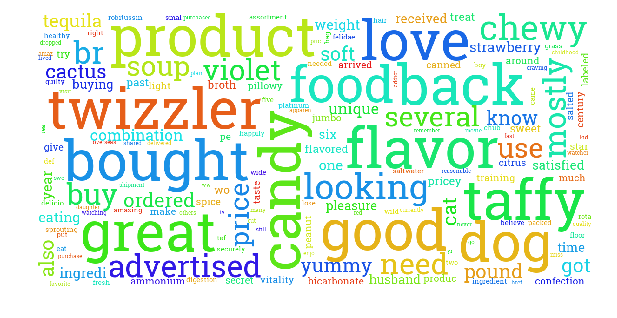

In [44]:
from colormap import Colormap
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from os import path
import os
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        font_path=os.path.join('fonts', 'RobotoSlab-Regular.ttf'),
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
#         Colormap="terrain",
        scale=3
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(10, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(amazon["text_Clean1"]) 

## Low Score reviews word cloud 

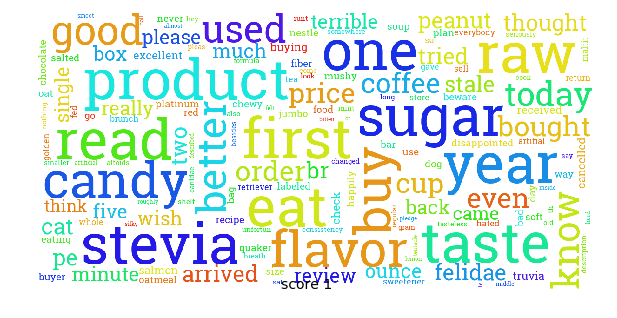

In [45]:
show_wordcloud(amazon[amazon.Score == 1]["text_Clean1"], title = "score 1")

## High Score reviews word cloud

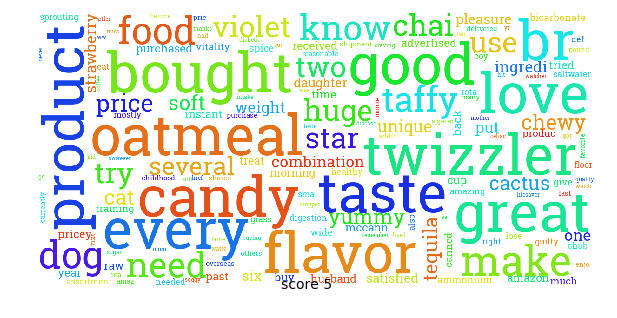

In [46]:
show_wordcloud(amazon[amazon.Score == 5]["text_Clean1"], title = "score 5")

In [47]:
from collections import Counter

In [48]:
Counter(" ".join(amazon['text_Clean1']).split()).most_common(20)

[('br', 647092),
 ('like', 267985),
 ('taste', 218448),
 ('good', 202405),
 ('product', 200191),
 ('one', 193151),
 ('flavor', 187631),
 ('coffee', 176301),
 ('great', 167189),
 ('love', 164003),
 ('tea', 153812),
 ('food', 153375),
 ('would', 124295),
 ('get', 119526),
 ('make', 107889),
 ('dog', 107697),
 ('amazon', 106607),
 ('time', 101634),
 ('really', 101073),
 ('much', 93212)]

# 2. Modeling 

## Splitting the data into train and test

In [50]:
df = pd.read_csv('amazon_clean.csv')
df.head(3)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date_time,date,Helpful_pct,chk,text_Clean1
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011-04-27,1.0,False,bought several vitality canned dog food produc...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012-09-07,NaN,False,product arrived labeled jumbo salted peanut pe...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008-08-18,1.0,False,confection around century light pillowy citrus...


In [51]:
df.shape

(568412, 16)

In [52]:
df.HelpfulnessDenominator.describe()

count    568412.000000
mean          2.227872
std           8.288745
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         923.000000
Name: HelpfulnessDenominator, dtype: float64

In [53]:
#include reviews that have more than 10 helpfulness data point only
df1 = df[(df.HelpfulnessDenominator > 10)].copy()
df1.shape 

(21437, 16)

In [54]:
#set up target variable -transform Helpfulness into a binary variable
threshold = 0.7
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'HelpfulnessNumerator'] \
                                 / df1.loc[:, 'HelpfulnessDenominator'] > threshold, 1, 0)
df1.head(7)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date_time,date,Helpful_pct,chk,text_Clean1,Helpful
32,32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,2006-11-13,2006-11-13,1.000000,False,mccann instant oatmeal great must oatmeal scra...,1
33,33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,1166313600,Good Instant,This is a good instant oatmeal from the best o...,2006-12-17,2006-12-17,1.000000,False,good instant oatmeal best oatmeal brand us can...,1
82,82,83,B003ZFRKGO,A2VOZX7YBT0D6D,"Johnnycakes ""Johnnycakes""",15,15,5,1325635200,Forget Molecular Gastronomy - this stuff rocke...,I know the product title says Molecular Gastro...,2012-01-04,2012-01-04,1.000000,False,know product title say molecular gastronomy le...,1
158,158,159,B000ITVLE2,A3NID9D9WMIV01,"Louie Arrighi ""Lou da Joo""",17,19,5,1260057600,tastes very fresh,"<span class=""tiny""> Length:: 0:26 Mins<br /><b...",2009-12-06,2009-12-06,0.894737,False,span class tiny length 0 26 min br br span exp...,1
287,287,288,B001UJEN6C,A1XM65S80UQ2MD,Joseph Kagan,13,13,5,1276214400,Great Natural Energy,"This is a fantastic product, and I wish it was...",2010-06-11,2010-06-11,1.000000,False,fantastic product wish readily available store...,1
324,324,325,B000JEHAHS,A2CU16YU1KEOUY,"Hurricane Ridge ""Chris""",5,19,1,1168300800,Never Arrived,So we cancelled the order. It was cancelled w...,2007-01-09,2007-01-09,0.263158,False,cancelled order cancelled without problem posi...,0
381,381,382,B003YXWAF8,A1KQXO716WOOD6,Allison Beegle,7,13,1,1309305600,Waste of money,These condiments are overpriced and terrible. ...,2011-06-29,2011-06-29,0.538462,False,condiment overpriced terrible classic disgusti...,0


In [55]:
df1.shape

(21437, 17)

In [56]:
print ('Count:')
display(df1.groupby('Helpful').count())

Count:


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date_time,date,Helpful_pct,chk,text_Clean1
Helpful,,,,,,,,,,,,,,,,
0,5909,5909,5909,5909,5909,5909,5909,5909,5909,5909,5909,5909,5909,5909,5909,5909
1,15528,15528,15528,15528,15528,15528,15528,15528,15528,15528,15528,15528,15528,15528,15528,15528


#### Helpful vs helpless is 72% VS 28% 

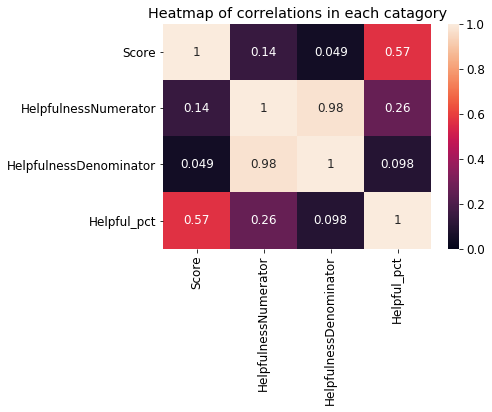

In [59]:
#Visualize correlation of the data
df2=df1[['Score','HelpfulnessNumerator','HelpfulnessDenominator','Helpful_pct']]
correlations = df2.corr()
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

In [61]:
#create a stemmer
stemmer = SnowballStemmer("english")

In [62]:
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
    #fit the vectorizers to the data.
features = vectorizer.fit_transform(df1['text_Clean1'])

In [63]:
df1['text_Clean1'].head()

32     mccann instant oatmeal great must oatmeal scra...
33     good instant oatmeal best oatmeal brand us can...
82     know product title say molecular gastronomy le...
158    span class tiny length 0 26 min br br span exp...
287    fantastic product wish readily available store...
Name: text_Clean1, dtype: object

In [71]:
RAN_STATE =42

In [72]:
X_train, X_test, y_train, y_test = train_test_split(features,df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

In [74]:
print("X_train shape: {}".format(X_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("X_test shape: {}".format(X_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

X_train shape: (17149, 993)
y_train shape: (17149,)

X_test shape: (4288, 993)
y_test shape: (4288,)



In [75]:
# Import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from time import time
from sklearn.metrics import roc_auc_score, roc_curve

In [76]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.2f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.2f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.2f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.2f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

In [77]:
#Random state for classifiers
RAN_STATE = 42
# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            RandomForestClassifier(random_state = RAN_STATE), 
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]
x_tr = X_train.toarray()
x_te = X_test.toarray()

# Set up the training set sizes for 100, 200 and 300 respectively.
train_feature_list = [x_tr[0:10000],x_tr[0:20000],x_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)

Training a GaussianNB using a training set size of 10000. . .
Trained model in 0.36 seconds
Made predictions in 0.20 seconds.
ROC_AUC score for training set: 0.79.
Made predictions in 0.07 seconds.
ROC_AUC score for test set: 0.75.

Training a GaussianNB using a training set size of 17149. . .
Trained model in 0.39 seconds
Made predictions in 0.44 seconds.
ROC_AUC score for training set: 0.78.
Made predictions in 0.07 seconds.
ROC_AUC score for test set: 0.75.

Training a GaussianNB using a training set size of 17149. . .
Trained model in 0.31 seconds
Made predictions in 0.40 seconds.
ROC_AUC score for training set: 0.78.
Made predictions in 0.07 seconds.
ROC_AUC score for test set: 0.75.

Training a RandomForestClassifier using a training set size of 10000. . .
Trained model in 0.86 seconds
Made predictions in 0.06 seconds.
ROC_AUC score for training set: 1.00.
Made predictions in 0.03 seconds.
ROC_AUC score for test set: 0.84.

Training a RandomForestClassifier using a training set s

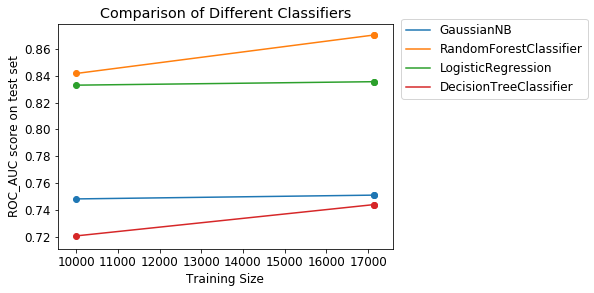

In [78]:
### Visualize differnet type of classifiers                                                               
FIG_SIZE = (26,20)
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show()

In [79]:
X_train2, X_test2, y_train, y_test = train_test_split(features, df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

In [80]:
from sklearn import grid_search, cross_validation
#make the grid search object
gs2 = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,5)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(y_train,n_folds=5),
    scoring='roc_auc'
)

#fit the grid search object to our new dataset
print ('Fitting grid search...')
gs2.fit(X_train2, y_train)
print ("Grid search fitted.")

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting grid search...
Grid search fitted.


In [81]:
#print the grid search scores.
print (gs2.best_estimator_)
gs2.grid_scores_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


[mean: 0.66042, std: 0.00581, params: {'C': 1e-05, 'class_weight': None},
 mean: 0.73998, std: 0.00843, params: {'C': 1e-05, 'class_weight': 'balanced'},
 mean: 0.66933, std: 0.00590, params: {'C': 0.0001, 'class_weight': None},
 mean: 0.74054, std: 0.00846, params: {'C': 0.0001, 'class_weight': 'balanced'},
 mean: 0.71191, std: 0.00703, params: {'C': 0.001, 'class_weight': None},
 mean: 0.74436, std: 0.00854, params: {'C': 0.001, 'class_weight': 'balanced'},
 mean: 0.76050, std: 0.00824, params: {'C': 0.01, 'class_weight': None},
 mean: 0.76774, std: 0.00854, params: {'C': 0.01, 'class_weight': 'balanced'},
 mean: 0.80662, std: 0.00810, params: {'C': 0.1, 'class_weight': None},
 mean: 0.81001, std: 0.00832, params: {'C': 0.1, 'class_weight': 'balanced'},
 mean: 0.82539, std: 0.00646, params: {'C': 1, 'class_weight': None},
 mean: 0.82600, std: 0.00650, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.82210, std: 0.00574, params: {'C': 10, 'class_weight': None},
 mean: 0.82146, s

ROC_AUC Score: 0.835597009086


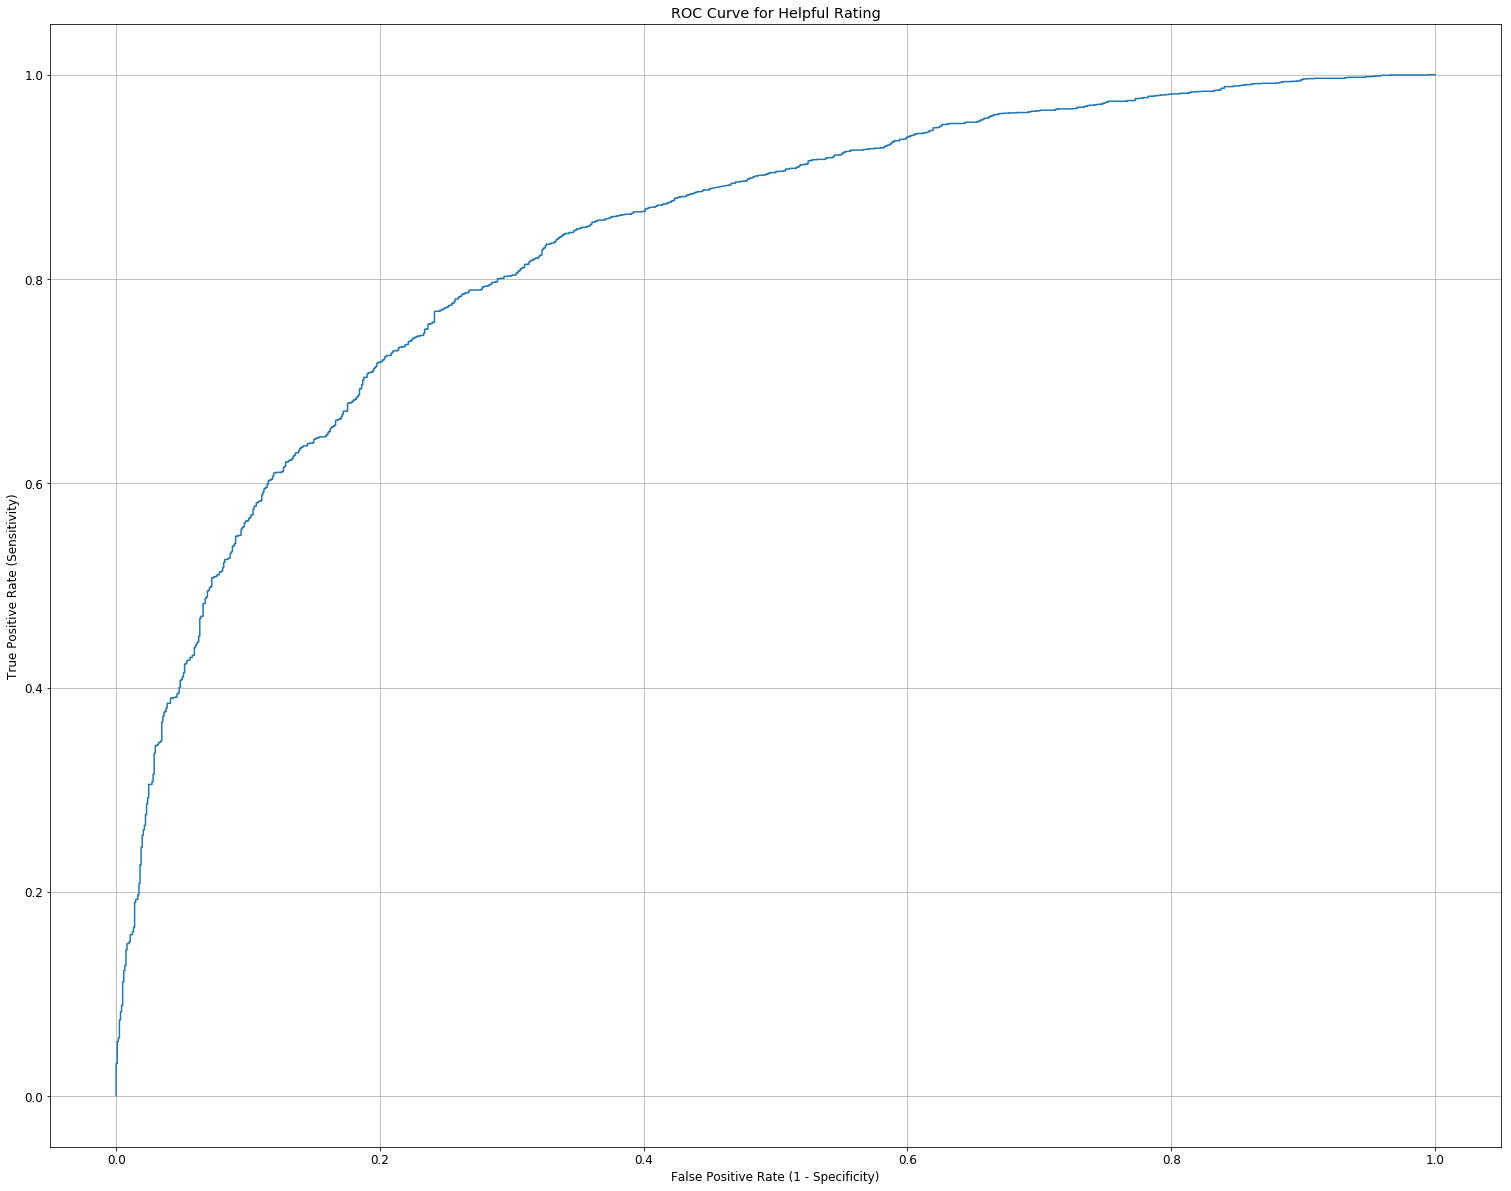

In [82]:
clf2 = gs2.best_estimator_
probas =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))